In [30]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import missingno as msno
import seaborn as sns
import scipy as sc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [31]:
# ouvrir les données 

df = pd.read_csv('fc_data.csv')
df.loc[:,'InvoiceDate'] = pd.to_datetime(df.InvoiceDate,errors='coerce')

# Création manuelle de caractéristiques
Ce notebook à pour vocation de créer des nouvelles caractéristiques susceptibles d'avoir une influence sur les comportement de consommation des utilisateurs. On tentera à partir de ces caractéristiques de déterminer des groupes d'utilisateurs aux comportements différents (voir notebook analyse_manual_model). Il convient de noter que la variable « description » s’avère difficilement utilisable pour obtenir des caractéristiques descriptives des items consommés. Cette dernière est en effet ambigüe et diffère largement pour des produits similaires. Un grand nombre de mots utilisés qui n'informent pas sur la nature de l'item rendant un travail de tokénisation très délicat. D'autre part, on rappellera que les caractéristiques utilisateurs basées sur la nature des items émerge de notre second modèle (modèle collaboratif) Les autres variables apportent toutes des informations pertinentes sur la manière de consommer des utilisateurs. On définie des caractéristiques non exhaustives (moyennes ou médiane) par utilisateur sur le nombre de transaction, le prix moyen par transaction, le nombre d'unités commandées moyen par transaction, le prix moyen par unité de transaction. Ce premier groupe de caractéristiques permet de prendre en compte la forme générale de la distribution des achats pour chaque utilisateur. On ajoute à cela des variables temporelles (heures et mois) et fréquencielles permettant de cibler le comportement des clients dans le temps et éventuellement de mettre en évidence des périodes plus propices aux achats pour certains clients (fêtes religieuses notamment) ou distinguer les grandes entreprises des petites entreprises (jour et heure de commande). On tient aussi compte du pays en supposant que les modes de consommation dépendent du fait que l'utilisateur soit basé à l'étranger ou non. Le nombre de transactions identiques moyen et le nombre de produits différents par transaction est aussi pris en compte mais ces caractéristiques ne sont pas déterminées par unité de temps. Enfin, on cherche à distinguer les nouveaux clients des anciens clients et de discrétiser les clients "perdus" de ceux dont la consommation s’accroît avec le temps. Pour cela, on définie la variable "date de dernière transaction". 
Il faudra préciser que la variable "fréquence moyenne de transaction" ne prend sens que lorsque l'utilisateur dont on cherche à prédire le comportement à déjà effectué un minimum de deux commandes. 
Les variables temporelles (jour de la semaine et heure) sont prises en compte dans 4 nouvelles caractéristiques. Jour(heure) du plus grand nombre de commandes et probabilité qu'une commande ai lieu le jour du plus grand nombre de commandes. Cette dernière variable peut être interpréter comme une manière d'évaluer la variance de la disparité de la consommation en fonction du jour (heure).
Suite à l'analyse du modèle collaboratif (notebook analyse_cf) nous proposons aussi de rajouter une variable : " score de popularité moyen des items consomés". Cette variable caractérise le propention de l'utilisateur à consommer des items "populaires" ou à se distinguer des autres consomateurs. 
Enfin, il convient de préciser que les variables transactionelles par mois ne sont pertinentes que pour des utilisateurs ayant initié leur première transaction préalablement au mois considéré. 

In [32]:
# Mélanger les données

df = shuffle(df)

In [33]:
# on rajoute une lettre N (pour number) avant chaque numéro de produit
df.loc[:,'InvoiceNo'] = 'N' + df['InvoiceNo'].astype(str) 

In [34]:
def plot_value_counts(col_name,df):       
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts())
    
    values_count.columns = ['count']
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    return (values_count)

In [6]:
df.columns

Index(['Unnamed: 0', 'InvoiceNo', 'StockCode', 'Description', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'Country_bis'],
      dtype='object')

# >  Créer un jeux de test et un jeux qui servira pour le clustering

La première étape est de garder un certain ratio d'utilisateurs ainsi que l'ensemble des transactions qui leurs correspondent dans le but de pouvoir tester la performance de notre (nos) modèles. Le jeux d'entrainement, quand à lui, sera utilisé pour réaliser le clustering et sera la base de l'entrainement d'un modèle supervisé reposant sur les labels résultant de la segmentation. 

In [35]:
valeurs_users = plot_value_counts('CustomerID',df=df)
# supprimer les utilisateurs inconnus 
valeurs_users = valeurs_users.iloc[1::,:]

# mélanger les données 
valeurs_users = shuffle(valeurs_users)

In [36]:
# jeux de test (25%)
m = int(np.around(valeurs_users.shape[0]/4))

test_vu = valeurs_users.iloc[0:m,:]
train_vu = valeurs_users.iloc[m::,:]
        

In [37]:
# associer les transactions aux deux jeux respectifs : 

df_test = df[(df.loc[:,'CustomerID'].isin(test_vu.iloc[:,0]))].reset_index(drop=True)

df_train = df[(df.loc[:,'CustomerID'].isin(train_vu.iloc[:,0]))].reset_index(drop=True)

In [91]:
print (df_test.shape, df_train.shape)

(88600, 10) (298211, 10)


In [92]:
# sauver le jeu d'entrainement et le jeu de test :

df_train.to_csv("df_train.csv")

df_test.to_csv("df_test.csv")

In [24]:
# modèle sans les mois mais en considérant tous les utilisateurs 

ind_date = df.columns.get_loc('InvoiceDate')
df['DAY'] = df.iloc[:,ind_date].dt.dayofyear

def features(df,ind):
    
    ind_date = df.columns.get_loc('InvoiceDate')
    
    df['DAY'] = df.iloc[:,ind_date].dt.weekday    
    df['MONTH'] = df.iloc[:,ind_date].dt.month    
    df['HOUR'] = df.iloc[:,ind_date].dt.hour
    
    
    # repérer les indices
    ind_h = df.columns.get_loc('HOUR')
    ind_m = df.columns.get_loc('MONTH')
    ind_m = df.columns.get_loc('DAY')
    ind_price = df.columns.get_loc('UnitPrice')
    ind_cust = df.columns.get_loc('CustomerID')
    ind_q = df.columns.get_loc('Quantity')
    
    ind_cbis = df.columns.get_loc('Country_bis')

    valeurs_cust = plot_value_counts('CustomerID',df=df)    
      
    
    valeurs_month = plot_value_counts('MONTH',df=df)
    valeurs_month.iloc[:,0] = pd.to_numeric(valeurs_month.iloc[:,0], errors='coerce').fillna(0, downcast='infer')
    
    
    
    # ---------------------------------------- Associer les caractéristiques moyennes ------------------------------------

    #définir un vecteur numpy
    vect = np.zeros(valeurs_cust.shape[0])
    dataset_clust = valeurs_cust.iloc[:,[0]]

    #ajouter les nouvelles caractéristiques
    dataset_clust['lasttransaction'] = vect[:]
    dataset_clust['nb_unit'] = vect[:]
    dataset_clust['prix_unit'] = vect[:]
    dataset_clust['montant'] = vect[:]
    dataset_clust['pays'] = vect[:]
    dataset_clust['nb_produit_diff'] = vect[:]
    dataset_clust['nb_produit_id'] = vect[:]       
    dataset_clust['frequence'] = vect[:]
    
    
    # tenir compte du jour de la semaine et de l'heure des transactions par 4 nouvelles variables
    # le jour(heure) comptant le plus grand nombre de transaction (0 à 7) et la probabilité de transaction 
    # ce jour(heure) ie le ratio nombre de transaction enregistrées le jour du maximum de transaction sur le nombre total
    # de transactions
    dataset_clust['jourmax'] = vect[:]
    dataset_clust['heuremax'] = vect[:]
    dataset_clust['jourprob'] = vect[:]
    dataset_clust['heureprob'] = vect[:]

    # associer la valeur 1 lorsque le pays est uk et 0 sinon
    df['Country_bis'][df.loc[:,'Country_bis'] == 'UK'] = 1
    df['Country_bis'][df.loc[:,'Country_bis'] == 'Foreign'] = 0
    
    # ------------------------- popularité ---------------------------------------------    
    # on rajoute une nouvelle variable inspirée du modèle collaboratif "la popularité"
    dataset_clust['pop1'] = vect[:]
    dataset_clust['pop2'] = vect[:]
    
    if (ind == 0):
    
        valeurs_items = plot_value_counts('StockCode',df=df)
        vect = np.zeros(valeurs_items.shape[0])
        valeurs_items['pop1'] = vect[:]
        valeurs_items['pop2'] = vect[:]

        # on associe à chaque item deux indicateur de popularité 
        for i in range (valeurs_items.shape[0]):
            df_trans = df[df.loc[:,'StockCode'] == valeurs_items.iloc[i,0]]
            valeurs_items.iloc[i,3] = df_trans.shape[0]/df.shape[0]
            valeurs_items.iloc[i,4] = (np.sum(df_trans.iloc[:,ind_price].multiply(df_trans.iloc[:,ind_q]))/
                                      (np.sum(df.iloc[:,ind_price].multiply(df.iloc[:,ind_q]))))    
        #----------------------------------------------------------------------------------
    if (ind == 1):
        
        valeurs_items = pd.read_csv('valeurs_items.csv')


    # remplir les colonnes 
    for i in range (dataset_clust.shape[0]):
        
        df_trans =  df[df.iloc[:,ind_cust] == valeurs_cust.iloc[i,0]] 
        
        dataset_clust.loc[i,'nb_unit'] = np.mean(df_trans.iloc[:,ind_q])
        dataset_clust.loc[i,'prix_unit'] = np.mean(df_trans.iloc[:,ind_price])
        dataset_clust.loc[i,'montant'] = np.mean(df_trans.iloc[:,ind_price].multiply(df_trans.iloc[:,ind_q]))
        dataset_clust.loc[i,'pays'] = df_trans.iloc[0,ind_cbis]
        dataset_clust.loc[i,'frequence'] = (np.amax(df_trans.loc[:,'InvoiceDate']) - 
                                            np.amin(df_trans.loc[:,'InvoiceDate']))/df_trans.shape[0]
        
        # convertir le temps en seconde      
        dataset_clust.loc[i,'frequence'] = dataset_clust.loc[i,'frequence'].total_seconds()
        dataset_clust.loc[i,'frequence'] = float(dataset_clust.loc[i,'frequence'])
        
        
        dataset_clust.loc[i,'lasttransaction'] = (np.amax(df.loc[:,'InvoiceDate']) - 
                                            np.amax(df_trans.loc[:,'InvoiceDate']))
            
         # convertir le temps en seconde        
        dataset_clust.loc[i,'lasttransaction'] = dataset_clust.loc[i,'lasttransaction'].total_seconds()
        dataset_clust.loc[i,'lasttransaction'] = float(dataset_clust.loc[i,'lasttransaction'])        
       
        
        valeurs_day = plot_value_counts('DAY',df=df_trans)
        valeurs_day.iloc[:,0] = pd.to_numeric(valeurs_day.iloc[:,0], errors='coerce').fillna(0, downcast='infer')       
        dataset_clust.loc[i,'jourmax'] = valeurs_day.iloc[0,0]
        dataset_clust.loc[i,'jourprob'] = valeurs_day.iloc[0,1]/np.sum(valeurs_day.iloc[0,:])
        
        valeurs_hour = plot_value_counts('HOUR',df=df_trans)
        valeurs_hour.iloc[:,0] = pd.to_numeric(valeurs_hour.iloc[:,0], errors='coerce').fillna(0, downcast='infer')            
        dataset_clust.loc[i,'heuremax'] = valeurs_hour.iloc[0,0]    
        dataset_clust.loc[i,'heureprob'] = valeurs_hour.iloc[0,1]/np.sum(valeurs_hour.iloc[0,:])
        
        valeurs_invoice = plot_value_counts('InvoiceNo',df=df_trans)
        dataset_clust.loc[i,'nb_produit_diff'] = np.mean(valeurs_invoice.iloc[:,1])
        valeurs_identiques = plot_value_counts('StockCode',df=df_trans)
        dataset_clust.loc[i,'nb_produit_id'] = np.mean(valeurs_identiques.iloc[:,1]) 
        
        # popularité 
        # considérer les items communs entre valeurs_items et valeurs_identiques
        valeurs_pop = valeurs_items[(valeurs_items.loc[:,'StockCode'].isin(valeurs_identiques.iloc[:,0]))].reset_index(drop=True)
        # le score de popularité utilisateur est la moyenne des scores items 
        dataset_clust.loc[i,'pop1'] = np.mean(valeurs_pop.loc[:,'pop1'])
        dataset_clust.loc[i,'pop2'] = np.mean(valeurs_pop.loc[:,'pop2'])
    
     
    
    return (dataset_clust)

In [93]:
# générer les caractéristiques de clustering sur le jeux d'entrainement
folds = 1


for k in range (folds):     
      

    data_features = features(df_train,ind=0)      
        
    data_features.to_csv("data_features{}.csv".format(k))   

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [94]:
# générer les caractéristiques de clustering sur le jeux de test 
folds = 1


for k in range (folds):     
      

    data_features = features(df_test,ind=1)      
        
    data_features.to_csv("data_features{}_t.csv".format(k))   

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
# sauvegarder la carte des items 
ind_price = df.columns.get_loc('UnitPrice')
ind_cust = df.columns.get_loc('CustomerID')
ind_q = df.columns.get_loc('Quantity')
    
valeurs_items = plot_value_counts('StockCode',df=df_train)
vect = np.zeros(valeurs_items.shape[0])
valeurs_items['pop1'] = vect[:]
valeurs_items['pop2'] = vect[:]

# on associe à chaque item deux indicateur de popularité 
for i in range (valeurs_items.shape[0]):
    df_trans = df[df.loc[:,'StockCode'] == valeurs_items.iloc[i,0]]
    valeurs_items.iloc[i,3] = df_trans.shape[0]/df.shape[0]
    valeurs_items.iloc[i,4] = (np.sum(df_trans.iloc[:,ind_price].multiply(df_trans.iloc[:,ind_q]))/
                                (np.sum(df.iloc[:,ind_price].multiply(df.iloc[:,ind_q]))))   
    
valeurs_items.to_csv("valeurs_items.csv")   

517742
65614
151133
207465
258197
288577
326244
360850
394832
424803


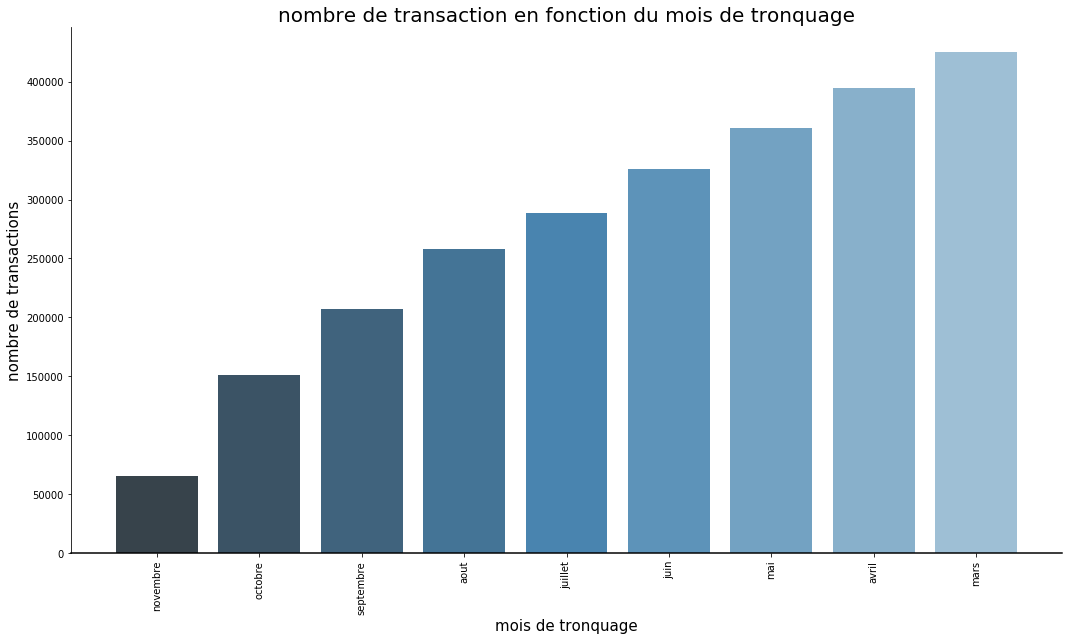

In [38]:
# on étudie le nombre de transaction du jeux de donné si en tronquant la date

ind_date = df.columns.get_loc('InvoiceDate')
df['DAY'] = df.iloc[:,ind_date].dt.dayofyear
 
list_trans = []
list_name = []
# sans tronquer
print (df.shape[0])
# après novembre
print (df[df.loc[:,'DAY'] > 334].shape[0])
list_trans.append(df[df.loc[:,'DAY'] > 334].shape[0])
list_name.append('novembre')
# après octobre 
print (df[df.loc[:,'DAY'] > 303].shape[0])
list_trans.append(df[df.loc[:,'DAY'] > 303].shape[0])
list_name.append('octobre')
# après septembre 
print (df[df.loc[:,'DAY'] > 272].shape[0])
list_trans.append(df[df.loc[:,'DAY'] > 272].shape[0])
list_name.append('septembre')
# après aout 
print (df[df.loc[:,'DAY'] > 241].shape[0])
list_trans.append(df[df.loc[:,'DAY'] > 241].shape[0])
list_name.append('aout')
# après juillet
print (df[df.loc[:,'DAY'] > 211].shape[0])
list_trans.append(df[df.loc[:,'DAY'] > 211].shape[0])
list_name.append('juillet')
# après juin
print (df[df.loc[:,'DAY'] > 180].shape[0])
list_trans.append(df[df.loc[:,'DAY'] > 180].shape[0])
list_name.append('juin')
# après mai
print (df[df.loc[:,'DAY'] > 150].shape[0])
list_trans.append(df[df.loc[:,'DAY'] > 150].shape[0])
list_name.append('mai')
# après avril
print (df[df.loc[:,'DAY'] > 119].shape[0])
list_trans.append(df[df.loc[:,'DAY'] > 119].shape[0])
list_name.append('avril')
# après mars
print (df[df.loc[:,'DAY'] > 89].shape[0])
list_trans.append(df[df.loc[:,'DAY'] > 89].shape[0])
list_name.append('mars')




# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

# occurence en valeurs non manquantes
y1 = list_trans[:]
g = sns.barplot(x=list_name[:], y=y1, palette='Blues_d', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)

# affiche uniquement un certain nombre de films en légende
plt.locator_params(axis='x', nbins=65)
#ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlabel("mois de tronquage",fontsize=15)
ax1.set_ylabel("nombre de transactions",fontsize=15)
#plt.axis([0, 365, 0, 40])

# Finalize the plot
g = sns.despine(bottom=True)
plt.xticks(rotation=90)
plt.title("nombre de transaction en fonction du mois de tronquage",fontsize=20)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('fig_commandes_utilisateurs.png', dpi=400)

# Considérer les mois (pour des utilisateurs dont la première transaction est inferieure à fin janvier)

In [12]:
# modèle avec les mois mais avec tronquage pour le mois de novembre


def features_c(df):
    
    ind_date = df.columns.get_loc('InvoiceDate')
    df['DAY'] = df.iloc[:,ind_date].dt.weekday    
    df['MONTH'] = df.iloc[:,ind_date].dt.month    
    df['HOUR'] = df.iloc[:,ind_date].dt.hour
    
    
    # repérer les indices
    ind_h = df.columns.get_loc('HOUR')
    ind_m = df.columns.get_loc('MONTH')
    ind_m = df.columns.get_loc('DAY')
    ind_price = df.columns.get_loc('UnitPrice')
    ind_cust = df.columns.get_loc('CustomerID')
    ind_q = df.columns.get_loc('Quantity')
    
    ind_cbis = df.columns.get_loc('Country_bis')

    valeurs_cust = plot_value_counts('CustomerID',df=df)    
      
    
    valeurs_month = plot_value_counts('MONTH',df=df)
    valeurs_month.iloc[:,0] = pd.to_numeric(valeurs_month.iloc[:,0], errors='coerce').fillna(0, downcast='infer')
    
    
    
    # ---------------------------------------- Associer les caractéristiques moyennes ------------------------------------

    #définir un vecteur numpy
    vect = np.zeros(valeurs_cust.shape[0])
    dataset_clust = valeurs_cust.iloc[:,[0]]

    #ajouter les nouvelles caractéristiques
    dataset_clust['lasttransaction'] = vect[:]
    dataset_clust['nb_unit'] = vect[:]
    dataset_clust['prix_unit'] = vect[:]
    dataset_clust['montant'] = vect[:]
    dataset_clust['pays'] = vect[:]
    dataset_clust['nb_produit_diff'] = vect[:]
    dataset_clust['nb_produit_id'] = vect[:]       
    dataset_clust['frequence'] = vect[:]
    
        
    # tenir compte du jour de la semaine et de l'heure des transactions par 4 nouvelles variables
    # le jour(heure) comptant le plus grand nombre de transaction (0 à 7) et la probabilité de transaction 
    # ce jour(heure) ie le ratio nombre de transaction enregistrées le jour du maximum de transaction sur le nombre total
    # de transactions
    dataset_clust['jourmax'] = vect[:]
    dataset_clust['heuremax'] = vect[:]
    dataset_clust['jourprob'] = vect[:]
    dataset_clust['heureprob'] = vect[:]

    # associer la valeur 1 lorsque le pays est uk et 0 sinon
    df['Country_bis'][df.loc[:,'Country_bis'] == 'UK'] = 1
    df['Country_bis'][df.loc[:,'Country_bis'] == 'Foreign'] = 0
    
    # ------------------------- popularité ---------------------------------------------    
    # on rajoute une nouvelle variable inspirée du modèle collaboratif "la popularité"
    dataset_clust['pop1'] = vect[:]
    dataset_clust['pop2'] = vect[:]
    
    valeurs_items = plot_value_counts('StockCode',df=df)  
    vect = np.zeros(valeurs_items.shape[0])
    valeurs_items['pop1'] = vect[:]
    valeurs_items['pop2'] = vect[:]
    
    # on associe à chaque item deux indicateur de popularité 
    for i in range (valeurs_items.shape[0]):
        df_trans = df[df.loc[:,'StockCode'] == valeurs_items.iloc[i,0]]
        valeurs_items.iloc[i,3] = df_trans.shape[0]/df.shape[0]
        valeurs_items.iloc[i,4] = (np.sum(df_trans.iloc[:,ind_price].multiply(df_trans.iloc[:,ind_q]))/
                                  (np.sum(df.iloc[:,ind_price].multiply(df.iloc[:,ind_q]))))    
    #----------------------------------------------------------------------------------

    # remplir les colonnes 
    for i in range (dataset_clust.shape[0]):
        
        df_trans =  df[df.iloc[:,ind_cust] == valeurs_cust.iloc[i,0]] 
        
        dataset_clust.loc[i,'nb_unit'] = np.mean(df_trans.iloc[:,ind_q])
        dataset_clust.loc[i,'prix_unit'] = np.mean(df_trans.iloc[:,ind_price])
        dataset_clust.loc[i,'montant'] = np.mean(df_trans.iloc[:,ind_price].multiply(df_trans.iloc[:,ind_q]))
        dataset_clust.loc[i,'pays'] = df_trans.iloc[0,ind_cbis]
        dataset_clust.loc[i,'frequence'] = (np.amax(df_trans.loc[:,'InvoiceDate']) - 
                                            np.amin(df_trans.loc[:,'InvoiceDate']))/df_trans.shape[0]
        
        # convertir le temps en seconde      
        dataset_clust.loc[i,'frequence'] = dataset_clust.loc[i,'frequence'].total_seconds()
        dataset_clust.loc[i,'frequence'] = float(dataset_clust.loc[i,'frequence'])
        
        
        dataset_clust.loc[i,'lasttransaction'] = (np.amax(df.loc[:,'InvoiceDate']) - 
                                            np.amax(df_trans.loc[:,'InvoiceDate']))
            
         # convertir le temps en seconde        
        dataset_clust.loc[i,'lasttransaction'] = dataset_clust.loc[i,'lasttransaction'].total_seconds()
        dataset_clust.loc[i,'lasttransaction'] = float(dataset_clust.loc[i,'lasttransaction'])        
       
        
        valeurs_day = plot_value_counts('DAY',df=df_trans)
        valeurs_day.iloc[:,0] = pd.to_numeric(valeurs_day.iloc[:,0], errors='coerce').fillna(0, downcast='infer')       
        dataset_clust.loc[i,'jourmax'] = valeurs_day.iloc[0,0]
        dataset_clust.loc[i,'jourprob'] = valeurs_day.iloc[0,1]/np.sum(valeurs_day.iloc[0,:])
        
        valeurs_hour = plot_value_counts('HOUR',df=df_trans)
        valeurs_hour.iloc[:,0] = pd.to_numeric(valeurs_hour.iloc[:,0], errors='coerce').fillna(0, downcast='infer')            
        dataset_clust.loc[i,'heuremax'] = valeurs_hour.iloc[0,0]    
        dataset_clust.loc[i,'heureprob'] = valeurs_hour.iloc[0,1]/np.sum(valeurs_hour.iloc[0,:])
        
        valeurs_invoice = plot_value_counts('InvoiceNo',df=df_trans)
        dataset_clust.loc[i,'nb_produit_diff'] = np.mean(valeurs_invoice.iloc[:,1])
        valeurs_identiques = plot_value_counts('StockCode',df=df_trans)
        dataset_clust.loc[i,'nb_produit_id'] = np.mean(valeurs_identiques.iloc[:,1])
        
        # popularité 
        # considérer les items communs entre valeurs_items et valeurs_identiques
        valeurs_pop = valeurs_items[(valeurs_items.loc[:,'StockCode'].isin(valeurs_identiques.iloc[:,0]))].reset_index(drop=True)
        # le score de popularité utilisateur est la moyenne des scores items 
        dataset_clust.loc[i,'pop1'] = np.mean(valeurs_pop.loc[:,'pop1'])
        dataset_clust.loc[i,'pop2'] = np.mean(valeurs_pop.loc[:,'pop2'])

                
        
         # repérer les indices
    ind_h = df.columns.get_loc('HOUR')
    ind_m = df.columns.get_loc('MONTH')
    ind_price = df.columns.get_loc('UnitPrice')
    ind_cust = df.columns.get_loc('CustomerID')
    ind_q = df.columns.get_loc('Quantity')    
    
    # --------------------------Associer les caractéristiques moyennes par jours et par mois ----------------------------

    # définir la liste nombre de transaction / nombre d'unité moyenne par transaction
    list_trans = ['trans','unit','p_unit','spend']

  
    #crer le dataset "user"
    d = {'user': valeurs_cust.iloc[:,0], 'nb_trans': valeurs_cust.iloc[:,1]}
    Users = pd.DataFrame(data=d)

    #définir un vecteur numpy
    vect = np.zeros(Users.shape[0])
    
    # order valeurs by month        
    valeurs_month = valeurs_month.sort_values(by='MONTH', ascending=False) 
    valeurs_month.iloc[:,0] = pd.to_numeric(valeurs_month.iloc[:,0], errors='coerce').fillna(0, downcast='infer')

    # créer les colonnes pour les mois 
    for k in range (len(list_trans)):    
        for j in range(valeurs_month.shape[0]):            
            Users.loc[:,list_trans[k] + valeurs_month.iloc[j,0].astype(str) + 'M'] = vect[:]
    print ('dimension en considérant le nombre de transaction et nombre unite moyenne de transacton/utilisateur/mois' )

    for i in range (Users.shape[0]): 
        print (i)
        # remplir les colonnes 'month'
        for j in range (valeurs_month.shape[0]):
            
            df_trans =  df[(df.iloc[:,ind_m] == valeurs_month.iloc[j,0])&(df.iloc[:,ind_cust] == valeurs_cust.iloc[i,0])]
            Users.loc[i,'unit'+valeurs_month.iloc[j,0].astype(str)+'M'] = np.mean(df_trans.iloc[:,ind_q])
            Users.loc[i,'trans'+valeurs_month.iloc[j,0].astype(str)+'M'] = df_trans.shape[0]
            Users.loc[i,'p_unit'+valeurs_month.iloc[j,0].astype(str)+'M'] = np.mean(df_trans.iloc[:,ind_price])
            Users.loc[i,'spend'+valeurs_month.iloc[j,0].astype(str)+'M'] = np.mean(df_trans.iloc[:,ind_price].multiply(df_trans.iloc[:,ind_q]))

       
  
    # assembler les deux datasets : 
    
    df_manual = pd.concat([dataset_clust,Users], axis=1)    
    
     
    
    return (df_manual)

In [7]:
ind_date = df.columns.get_loc('InvoiceDate')
df['DAY'] = df.iloc[:,ind_date].dt.dayofyear

# repérer les utilisateurs correspondants à ce nouveau jeux de données

val_custom_t = plot_value_counts('CustomerID',df=df)

val_custom_t2 = val_custom_t.copy()

print (val_custom_t.shape)


for i in range (val_custom_t.shape[0]):
    df1 = df[df.loc[:,'CustomerID'] == val_custom_t.iloc[i,0]]
    # on tronque le jeux de donné à partir du mois de février
    if (np.min(df1.loc[:,'DAY']) > 30):
        val_custom_t2 = val_custom_t2[val_custom_t.iloc[:,0] != val_custom_t.iloc[i,0]]


# considérer un nouveau dataset prenant en compte uniquement ces utilisateurs

# ne garder que les utilisateurs communs entre df et val_custom_t
df_new = df[(df.loc[:,'CustomerID'].isin(val_custom_t2.iloc[:,0]))].reset_index(drop=True)
print (df_new.shape)


valeurs_users = plot_value_counts('CustomerID',df=df_new)
# supprimer les utilisateurs inconnus 
valeurs_users = valeurs_users.iloc[1::,:]

# mélanger les données 
valeurs_users = shuffle(valeurs_users)

# jeux de test (25%)
m = int(np.around(valeurs_users.shape[0]/4))

test_vu = valeurs_users.iloc[0:m,:]
train_vu = valeurs_users.iloc[m::,:]

# associer les transactions aux deux jeux respectifs : 

df_test_month = df_new[(df_new.loc[:,'CustomerID'].isin(test_vu.iloc[:,0]))].reset_index(drop=True)

df_train_month = df_new[(df_new.loc[:,'CustomerID'].isin(train_vu.iloc[:,0]))].reset_index(drop=True)

    
df_test_month.to_csv("df_test_month.csv")   

df_train_month.to_csv("df_train_month.csv")   


(4256, 3)


C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match Da

(281060, 11)


In [8]:
print (df_test_month.shape, df_train_month.shape)

(38957, 11) (111172, 11)


In [14]:

      
# déterminer les caractéristiques 
    
train_features = features_c(df_train_month)    
        
# sauver les données    
    
train_features.to_csv("trainXnov_features0.csv")
    
    

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


dimension en considérant le nombre de transaction et nombre unite moyenne de transacton/utilisateur/mois
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
2

In [44]:
# sauver le jeu d'entrainement et le jeu de test :

df_train.to_csv("df_train.csv")

df_test.to_csv("df_test.csv")
    

# Entrainer sur les 6 premiers mois et tester sur les 6 suivants


dans cette partie on souhaite définir un jeu d'entrainement servant à segmenter basé sur les 6 premiers mois. On utilisera aussi ce jeu dans la partie supervisée. Le jeu de test contient des utilisateurs différents et est testé sur les 6 mois suivants

In [39]:
# on étudie le nombre de transaction du jeux de donné si en tronquant la date

ind_date = df_train.columns.get_loc('InvoiceDate')
# ajouter une colonne jour de l'année 
df_test['DAY'] = df_test.iloc[:,ind_date].dt.dayofyear
df_train['DAY'] = df_train.iloc[:,ind_date].dt.dayofyear

# on étudie le nombre de transaction du jeux de donné si en tronquant la date

ind_date = df.columns.get_loc('InvoiceDate')
df['DAY'] = df.iloc[:,ind_date].dt.dayofyear

# entrainer sur la moitier de l'année
df_train2 = df_train[df_train.loc[:,'DAY']<200]
# prédire sur l'autre moitier
df_test2 = df_test[df_test.loc[:,'DAY']>200]

# sauver le jeu d'entrainement et le jeu de test :

df_train2.to_csv("df_train2.csv")

df_test2.to_csv("df_test2.csv")

print (df_train2.Country_bis)

data_features = features(df_train2,ind=0) 

data_features.to_csv("df_tr2.csv")   






1         Foreign
3              UK
6              UK
8              UK
9              UK
10        Foreign
12             UK
13             UK
14             UK
19             UK
20             UK
25             UK
29             UK
35             UK
36             UK
38             UK
40             UK
41             UK
42             UK
45             UK
46             UK
47             UK
48             UK
49        Foreign
53             UK
56             UK
57             UK
60             UK
64             UK
66             UK
           ...   
290180         UK
290182         UK
290183         UK
290184         UK
290185         UK
290187         UK
290188         UK
290189    Foreign
290193         UK
290194         UK
290195         UK
290198    Foreign
290200         UK
290201         UK
290203         UK
290210         UK
290214         UK
290216         UK
290217    Foreign
290219         UK
290223    Foreign
290224    Foreign
290226         UK
290229         UK
290231    

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t